#Extract Dataset

In [1]:
from zipfile import ZipFile
file_name="/content/drive/MyDrive/Dataset/Dog_Breed/dog-breed-identification.zip"

with ZipFile(file_name,'r') as Zip:
  Zip.extractall()
  print('Done')

Done


#Import

In [2]:
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import os
import time
import copy
torch.manual_seed(0)

#Custom Dataset

In [3]:
train_path = "/content/train"
test_path = "/content/test"
train_df = pd.read_csv("/content/labels.csv")
train_df.head() 

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# Convert categorical to numerical
all_labels = train_df['breed'].unique()
n_classes = len(all_labels)
label2index = dict(zip(all_labels, np.arange(len(all_labels), dtype=int)))
index2label = dict(zip(np.arange(len(all_labels), dtype=int), all_labels))
train_df.replace(label2index, inplace = True)

In [5]:
#Custom Dataset
class DogBreedDataset(Dataset):
  def __init__(self, imgs_path, label_fr, transform =None):
    # img_path: Directory with train images
    # label_fr: path to csv file with annotations.
    # transform: transform to apply dataset
    self.imgs_path = imgs_path
    self.label_fr = label_fr
    self.transform = transform
  def __len__(self):
    return len(self.label_fr)
  def __getitem__(self, index):
    img_id = "{}.jpg".format(self.label_fr.iloc[index, 0])
    img_pth = os.path.join(self.imgs_path, img_id)
    img = Image.open(img_pth)
    label = self.label_fr.iloc[index, 1]
    if self.transform:
      img = self.transform(img)
    return img, label

In [6]:
#Transform Data
data_augment= {
    "train": transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "val": transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

#Create Data Generator

In [7]:
train_data, val_data = train_test_split(train_df, test_size = 0.2, random_state = 0)
dataset_sizes = {"train": len(train_data), "val": len(val_data)}

In [8]:
batch_size = 64
#Train
train_dataset = DogBreedDataset(train_path, train_data, transform = data_augment['train'])
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)

#Validation
val_dataset = DogBreedDataset(train_path, val_data, transform = data_augment['val'])
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle=True)

dataloaders ={"train" : train_dataloader, "val":val_dataloader}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 224, 224)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    mean=torch.tensor([0.485, 0.456, 0.406], dtype= torch.float64).view(1,3,1,1)
    std=torch.tensor([0.229, 0.224, 0.225] ,dtype= torch.float64).view(1,3,1,1)
    img =  image_tensor *std +mean
    image_unflat = img.detach().cpu().view(-1, *size)
    fig = plt.figure(figsize=(10, 10))
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    image_grid = np.clip(image_grid, 0, 1)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

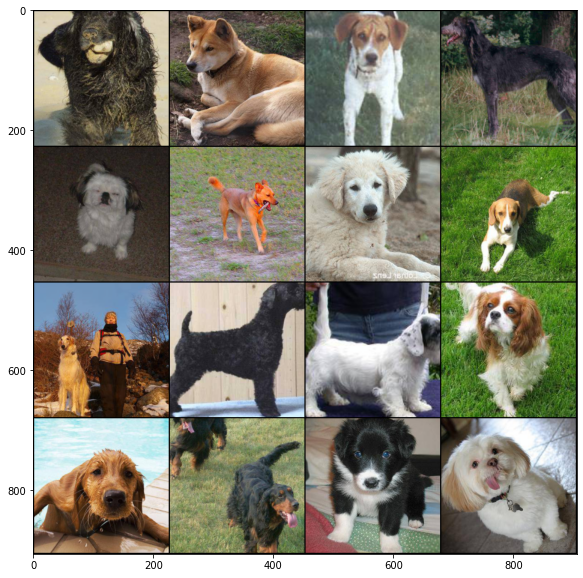

In [10]:
img,label = next(iter(dataloaders['train']))
show_tensor_images(img)

# Training Model

In [11]:
def train_model(model, criterion, optimizer, scheduler, epochs = 50):
  since = time.time()
  best_weights = copy.deepcopy(model.state_dict())
  best_acc =0.0

  for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs - 1}')
    print("-"*10)

    #Each epoch include training and validation phase
    for phase in ['train', 'val']:
      if phase =='train':
        model.train() # training mode
      else:
        model.eval() #validation mode

      running_loss= 0.0 
      running_corrects = 0

      #Iter over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
  
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')
  model.load_state_dict(best_weights)
  return model

In [12]:
model_conv = models.resnet50(weights =models.ResNet50_Weights.IMAGENET1K_V1)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, n_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, epochs=25)

Epoch 0/24
----------
train Loss: 2.0372 Acc: 0.5785
val Loss: 0.8441 Acc: 0.7980

Epoch 1/24
----------
train Loss: 0.6703 Acc: 0.8338
val Loss: 0.6468 Acc: 0.8249

Epoch 2/24
----------
train Loss: 0.4917 Acc: 0.8683
val Loss: 0.6336 Acc: 0.8137

Epoch 3/24
----------
train Loss: 0.3975 Acc: 0.8920
val Loss: 0.5780 Acc: 0.8323

Epoch 4/24
----------
train Loss: 0.3411 Acc: 0.9040
val Loss: 0.5686 Acc: 0.8298

Epoch 5/24
----------
train Loss: 0.2909 Acc: 0.9220
val Loss: 0.5708 Acc: 0.8342

Epoch 6/24
----------
train Loss: 0.2534 Acc: 0.9300
val Loss: 0.5962 Acc: 0.8191

Epoch 7/24
----------
train Loss: 0.1824 Acc: 0.9610
val Loss: 0.5202 Acc: 0.8450

Epoch 8/24
----------
train Loss: 0.1685 Acc: 0.9651
val Loss: 0.5174 Acc: 0.8435

Epoch 9/24
----------
train Loss: 0.1655 Acc: 0.9670
val Loss: 0.5278 Acc: 0.8381

Epoch 10/24
----------
train Loss: 0.1639 Acc: 0.9670
val Loss: 0.5252 Acc: 0.8460

Epoch 11/24
----------
train Loss: 0.1629 Acc: 0.9670
val Loss: 0.5266 Acc: 0.8357

Ep